In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Loading and preparing the data 

In [2]:
df = pd.read_csv("combined_financial_data.csv", index_col=0)
df['daily_volatility'] = df['price'] - df['open']
df.head()

,date,permno,ticker,price,volume,return,high,low,open,avg_price,mkt_cap,pct_return,ticker_attention,name_price_attention,daily_volatility
0,2014-01-02,10107,MSFT,37.16,30423757.0,-0.006683,37.40,37.10,37.350,37.25,308428000.0,-0.6683,3.25,3.15,-0.190
1,2014-01-03,10107,MSFT,36.91,30944370.0,-0.006728,37.22,36.60,37.200,36.91,306353000.0,-0.6728,3.38,1.54,-0.290
2,2014-01-06,10107,MSFT,36.13,43111355.0,-0.021133,36.89,36.11,36.850,36.50,299879000.0,-2.1133,4.03,2.24,-0.720
3,2014-01-07,10107,MSFT,36.41,35478667.0,0.007750,36.49,36.21,36.325,36.35,302203000.0,0.7750,4.94,1.19,0.085
4,2014-01-08,10107,MSFT,35.76,59452427.0,-0.017852,36.14,35.58,36.000,35.86,296808000.0,-1.7852,5.33,1.68,-0.240


In [3]:
df_test = pd.read_csv("quarterly_financial_data_2013_2023.csv")


#df_test = df_test.rename(columns = {'datedate': 'date'})
df_test['date'] = df_test['datadate']
df_test['ticker'] = df_test['tic']
df_test.head()

,gvkey,datadate,fqtr,tic,conm,net_income,revenue,total_assets,shareholders_equity,total_liabilities,total_debt,sales,operating_activities_cf,capital_expenditures,interest_expense,common_shares_outstanding,earnings_per_share,dividends_per_share,date,ticker
0,1690,2013-03-31,2,AAPL,APPLE INC,9547.0,43603.0,194743.0,135490.0,59253.0,0.0,43603.0,35930.0,4325.0,0.0,940.094,10.16,2.65,2013-03-31,AAPL
1,1690,2013-06-30,3,AAPL,APPLE INC,6900.0,35323.0,199856.0,123354.0,76502.0,16958.0,35323.0,43758.0,6210.0,53.0,908.442,7.51,3.05,2013-06-30,AAPL
2,1690,2013-09-30,4,AAPL,APPLE INC,7512.0,37472.0,207000.0,123549.0,83451.0,16960.0,37472.0,53666.0,8165.0,83.0,899.213,8.31,3.05,2013-09-30,AAPL
3,1690,2013-12-31,1,AAPL,APPLE INC,13072.0,57594.0,225184.0,129684.0,95500.0,16961.0,57594.0,22670.0,1985.0,84.0,892.447,14.59,3.05,2013-12-31,AAPL
4,1690,2014-03-31,2,AAPL,APPLE INC,10223.0,45646.0,205989.0,120179.0,85810.0,16962.0,45646.0,36208.0,3367.0,85.0,861.745,11.69,3.05,2014-03-31,AAPL


In [4]:
anomalies_df = pd.merge(df, df_test[['date','ticker','revenue', 'total_assets', 'earnings_per_share']], on=['date', 'ticker'], how = 'left')
anomalies_df['book_to_market'] = anomalies_df['total_assets'] / anomalies_df['mkt_cap']
anomalies_df['dt_date'] = pd.to_datetime(anomalies_df['date'])
anomalies_df['jan_dummy'] = (anomalies_df['dt_date'].dt.month == 1).astype(int)
anomalies_df['jan_dummy'] = anomalies_df['jan_dummy'].fillna(0)
anomalies_df['monday_dummy'] = (anomalies_df['dt_date'].dt.dayofweek == 0).astype(int)
anomalies_df['monday_dummy'] = anomalies_df['monday_dummy'].fillna(0)
anomalies_df['annual_rep_release'] = anomalies_df['book_to_market'].notna().astype(int)
anomalies_df['annual_rep_release'] = anomalies_df['annual_rep_release'].fillna(0)
#anomalies_df[anomalies_df['book_to_market'].notna()].head()
anomalies_df.head()

,date,permno,ticker,price,volume,return,high,low,open,avg_price,...,name_price_attention,daily_volatility,revenue,total_assets,earnings_per_share,book_to_market,dt_date,jan_dummy,monday_dummy,annual_rep_release
0,2014-01-02,10107,MSFT,37.16,30423757.0,-0.006683,37.40,37.10,37.350,37.25,...,3.15,-0.190,NaN,NaN,NaN,NaN,2014-01-02,1,0,0
1,2014-01-03,10107,MSFT,36.91,30944370.0,-0.006728,37.22,36.60,37.200,36.91,...,1.54,-0.290,NaN,NaN,NaN,NaN,2014-01-03,1,0,0
2,2014-01-06,10107,MSFT,36.13,43111355.0,-0.021133,36.89,36.11,36.850,36.50,...,2.24,-0.720,NaN,NaN,NaN,NaN,2014-01-06,1,1,0
3,2014-01-07,10107,MSFT,36.41,35478667.0,0.007750,36.49,36.21,36.325,36.35,...,1.19,0.085,NaN,NaN,NaN,NaN,2014-01-07,1,0,0
4,2014-01-08,10107,MSFT,35.76,59452427.0,-0.017852,36.14,35.58,36.000,35.86,...,1.68,-0.240,NaN,NaN,NaN,NaN,2014-01-08,1,0,0


### Start with OLS and robust Regression (inspecting the relationships)

In [5]:
# splitting the data 
fix_seed = 42

y = df['return']
X = df[['name_price_attention']]
X2 = df[['name_price_attention', 'mkt_cap']]
X3 = df[['name_price_attention', 'daily_volatility']]
X4 = df[['name_price_attention', 'volume']]
X5 = df[['name_price_attention', 'mkt_cap']]
X6 = df[['name_price_attention', 'mkt_cap']]
X7 = df[['name_price_attention', 'mkt_cap']]
X8 = df[['name_price_attention', 'mkt_cap']]
X9 = df[['name_price_attention', 'mkt_cap']]
X10 = df[['name_price_attention', 'mkt_cap']]
X11 =  df[['name_price_attention', 'mkt_cap']]






X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=fix_seed)

In [6]:
# create OLS regression for y and X
X_train = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     20.30
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           6.63e-06
Time:                        16:15:53   Log-Likelihood:             1.3403e+05
No. Observations:               51206   AIC:                        -2.681e+05
Df Residuals:                   51204   BIC:                        -2.680e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0003 

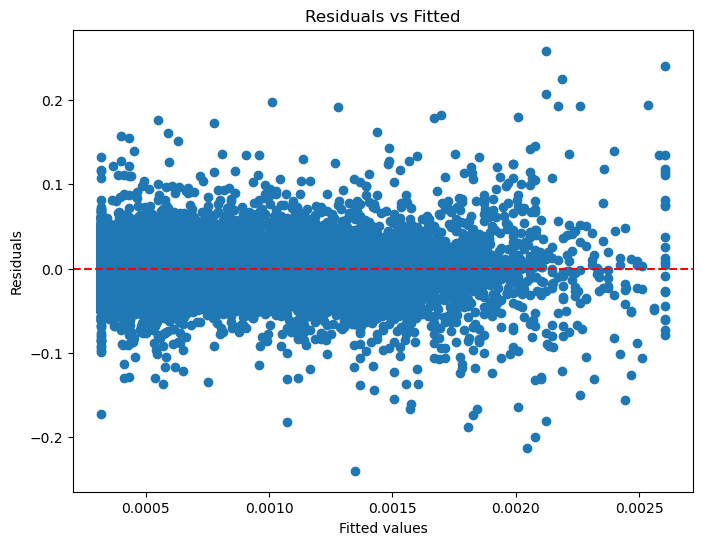

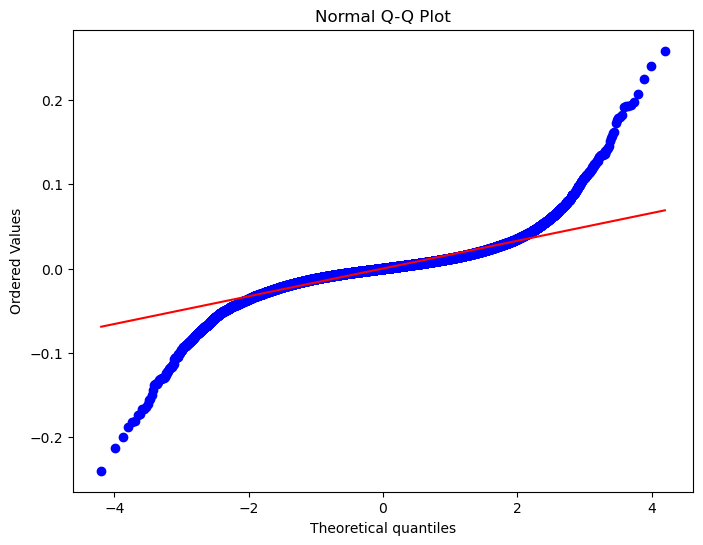

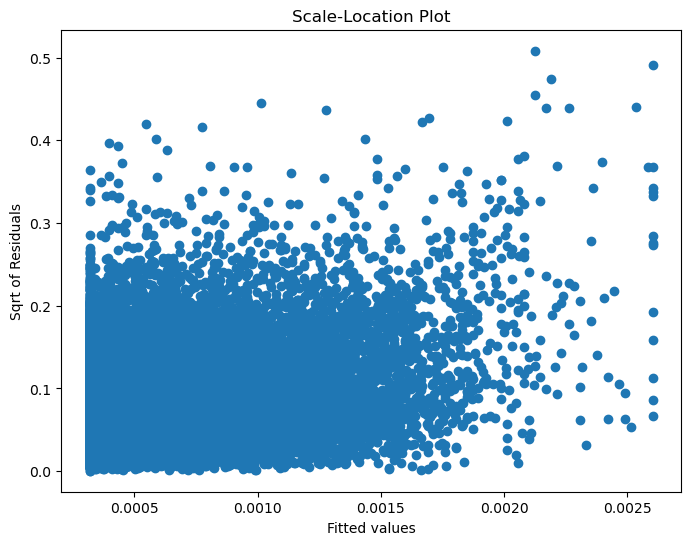

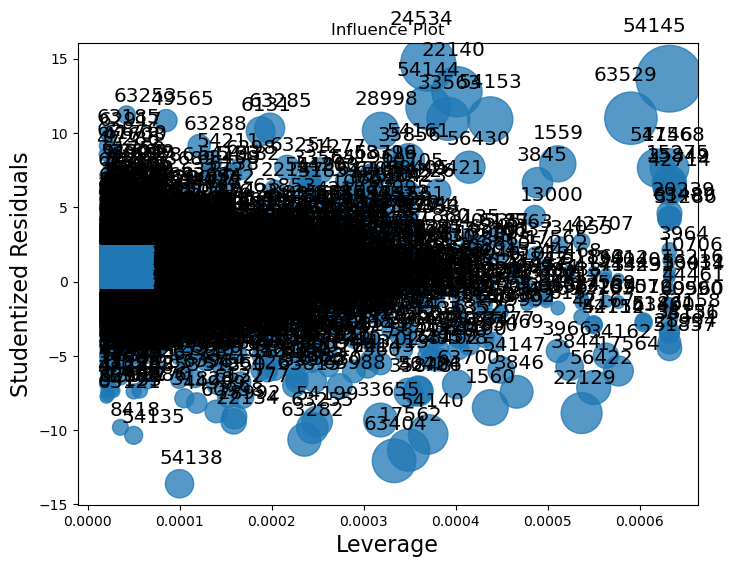

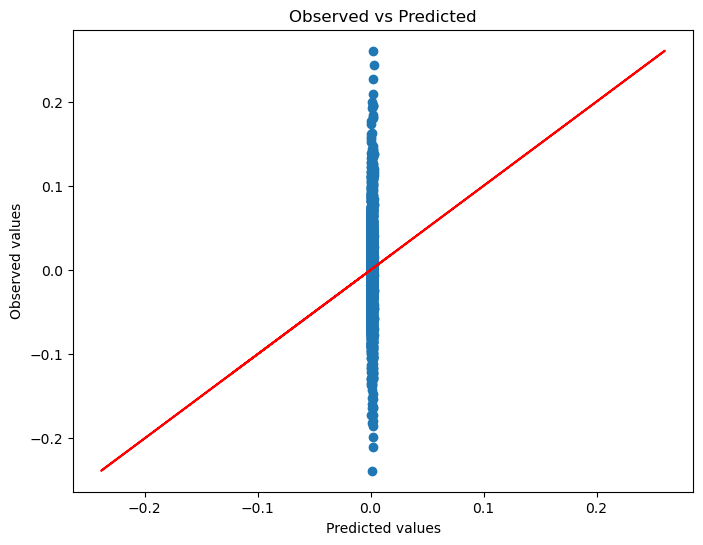

In [9]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

# Residuals vs Fitted plot for checking linearity
plt.figure(figsize=(8,6))
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Normal Q-Q plot for checking normality of residuals
plt.figure(figsize=(8,6))
stats.probplot(results.resid, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

# Scale-Location plot for checking homoscedasticity
plt.figure(figsize=(8,6))
plt.scatter(results.fittedvalues, results.resid**0.5)
plt.xlabel('Fitted values')
plt.ylabel('Sqrt of Residuals')
plt.title('Scale-Location Plot')
plt.show()

# Leverage plot for checking influential cases
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.influence_plot(results, ax=ax, criterion="cooks")
plt.title('Influence Plot')
plt.show()

# Observed vs Predicted plot for checking linearity
plt.figure(figsize=(8,6))
plt.scatter(results.fittedvalues, y_train)
plt.plot(y_train, y_train, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.title('Observed vs Predicted')
plt.show()


1. **Linearity**: The assumption of linearity is that the relationship between the independent variables and the dependent variable is linear. In the plot, we look for a random scatter of points around the horizontal axis (which has a red dashed line). If the points form a specific pattern (such as a curve), this could indicate that the relationship is not linear. In your plot, the scatter of points does not appear to show a clear pattern or systematic curve, which suggests that the linearity assumption is not violated.

2. **Equal Variance (Homoscedasticity)**: This assumption is that the residuals have constant variance at all levels of the fitted values. If the plot shows a funnel shape where the residuals spread out as the fitted values increase or decrease, it would indicate heteroscedasticity. The plot you've shown does seem to have a consistent spread across the range of fitted values, suggesting that the assumption of equal variance is not violated.

3. **Independence**: The residuals should be independent of each other, which means there shouldn't be clear trends or patterns in the residuals. The lack of a discernible pattern in your plot suggests that the residuals might be independent.

4. **Outliers**: Outliers can be identified as points that are far away from the rest distribution of the points. There are a few points that stand out from the cloud, especially at the higher end of the fitted values, which may be outliers. These could have a significant impact on the regression model and may need to be investigated further.

5. **Normality**: While this specific plot does not directly assess normality, if the residuals are normally distributed, they should be symmetrically distributed about the zero line. Your plot does not indicate any serious skewness, which is a good sign, but a Q-Q plot would be more appropriate for assessing normality.

Overall, based on this plot, the data seems to meet some of the key assumptions of linear regression. However, this is just one diagnostic tool, and it would be prudent to look at other plots (such as Q-Q plots for normality), leverage statistics, and conduct tests like the Breusch-Pagan test for heteroscedasticity to thoroughly evaluate the model's assumptions.

## Trying OLS with log Returns

In [15]:
import numpy as np

df['log_return'] = np.log(1 + df['return'])
df.head()

,date,permno,ticker,price,volume,return,high,low,open,avg_price,mkt_cap,pct_return,ticker_attention,name_price_attention,daily_volatility,log_return
0,2014-01-02,10107,MSFT,37.16,30423757.0,-0.006683,37.40,37.10,37.350,37.25,308428000.0,-0.6683,3.25,3.15,-0.190,-0.006705
1,2014-01-03,10107,MSFT,36.91,30944370.0,-0.006728,37.22,36.60,37.200,36.91,306353000.0,-0.6728,3.38,1.54,-0.290,-0.006751
2,2014-01-06,10107,MSFT,36.13,43111355.0,-0.021133,36.89,36.11,36.850,36.50,299879000.0,-2.1133,4.03,2.24,-0.720,-0.021359
3,2014-01-07,10107,MSFT,36.41,35478667.0,0.007750,36.49,36.21,36.325,36.35,302203000.0,0.7750,4.94,1.19,0.085,0.007720
4,2014-01-08,10107,MSFT,35.76,59452427.0,-0.017852,36.14,35.58,36.000,35.86,296808000.0,-1.7852,5.33,1.68,-0.240,-0.018013


In [16]:
fix_seed = 42

y = df['log_return']
X = df[['name_price_attention']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=fix_seed)

# create OLS regression for y and X
X_train = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.689
Date:                Mon, 04 Mar 2024   Prob (F-statistic):            0.00556
Time:                        16:39:40   Log-Likelihood:             1.3405e+05
No. Observations:               51206   AIC:                        -2.681e+05
Df Residuals:                   51204   BIC:                        -2.681e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0003 

In [ ]:
# create OLS regression for y and X
X_train = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train)
results = model.fit()
robust_results = results.get_robustcov_results()

print(robust_results.summary())

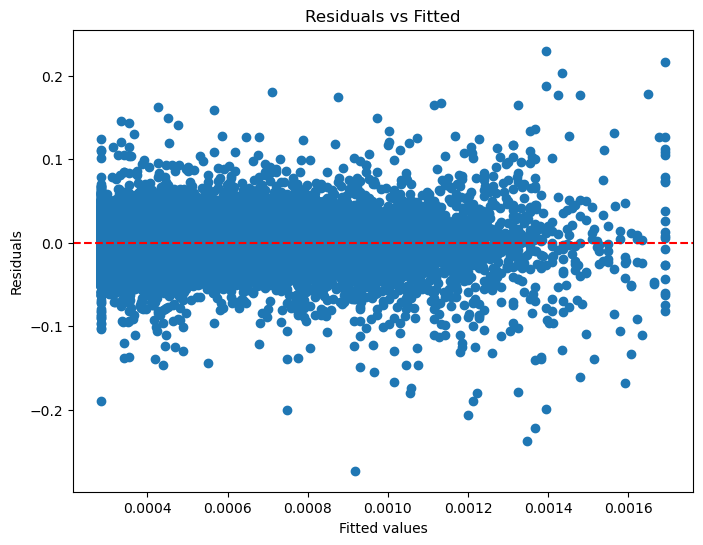

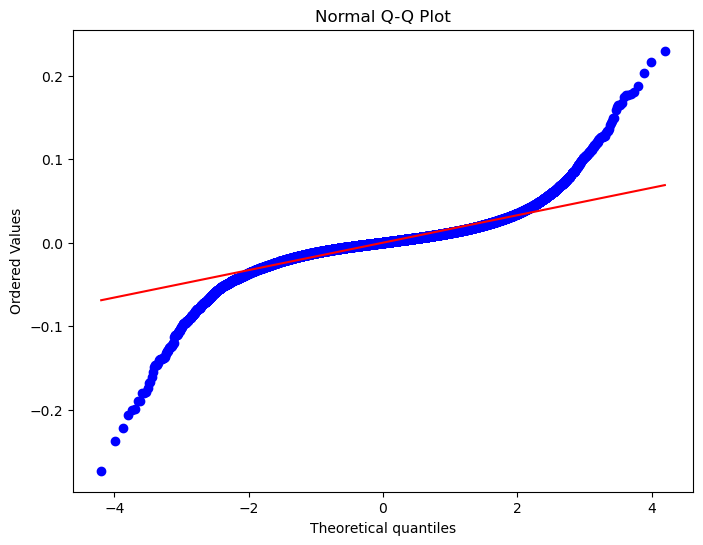

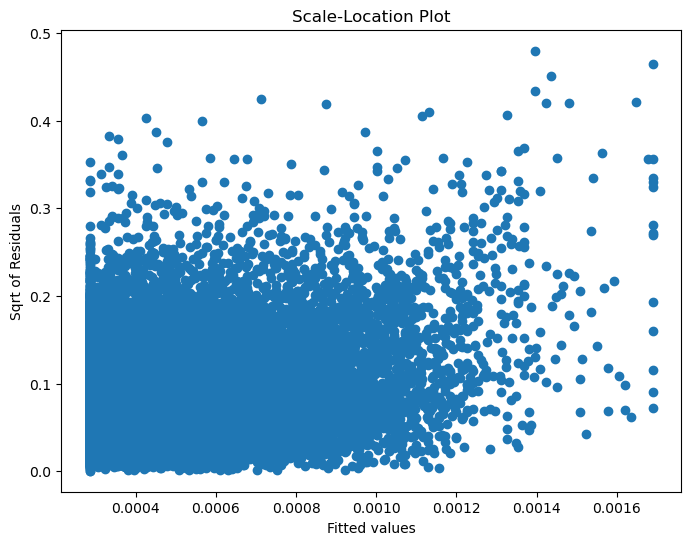

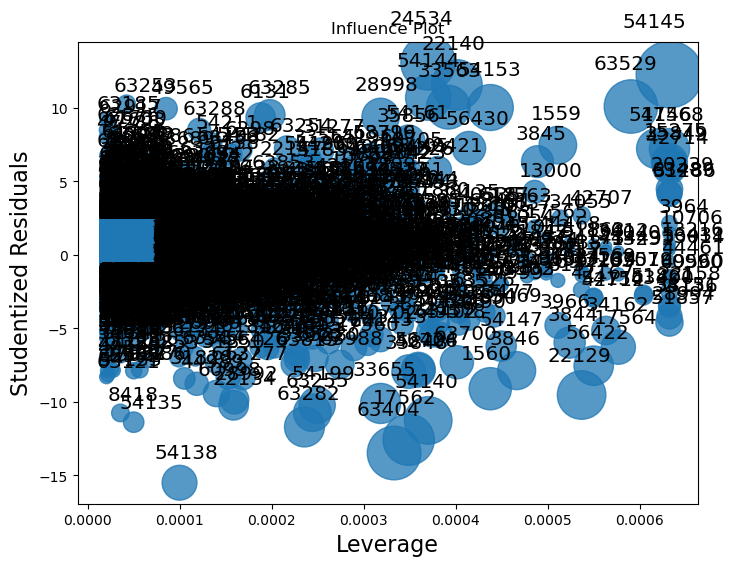

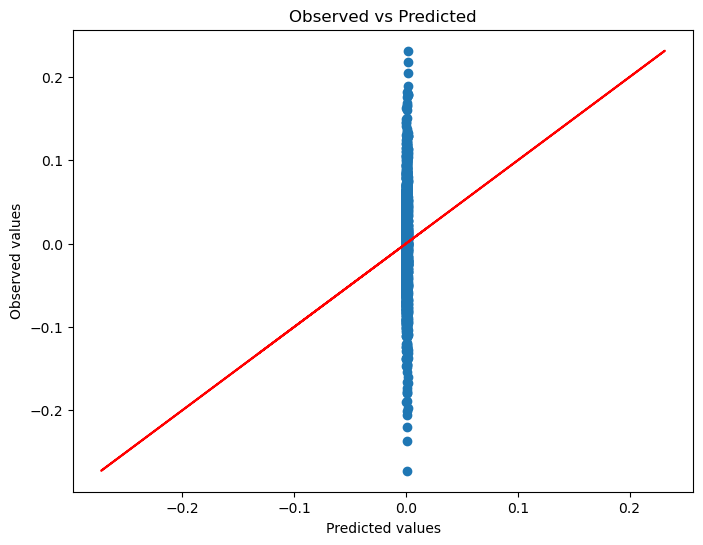

In [17]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

# Residuals vs Fitted plot for checking linearity
plt.figure(figsize=(8,6))
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Normal Q-Q plot for checking normality of residuals
plt.figure(figsize=(8,6))
stats.probplot(results.resid, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

# Scale-Location plot for checking homoscedasticity
plt.figure(figsize=(8,6))
plt.scatter(results.fittedvalues, results.resid**0.5)
plt.xlabel('Fitted values')
plt.ylabel('Sqrt of Residuals')
plt.title('Scale-Location Plot')
plt.show()

# Leverage plot for checking influential cases
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.influence_plot(results, ax=ax, criterion="cooks")
plt.title('Influence Plot')
plt.show()

# Observed vs Predicted plot for checking linearity
plt.figure(figsize=(8,6))
plt.scatter(results.fittedvalues, y_train)
plt.plot(y_train, y_train, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.title('Observed vs Predicted')
plt.show()

In [ ]:
# create OLS regression for y and X
X_train = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train)
results = model.fit()
robust_results = results.get_robustcov_results()

print(robust_results.summary())

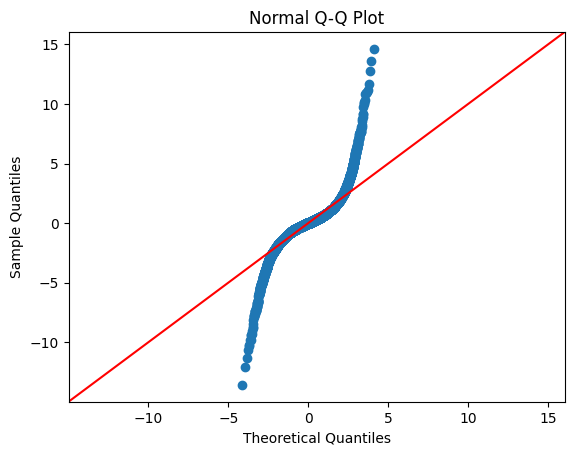

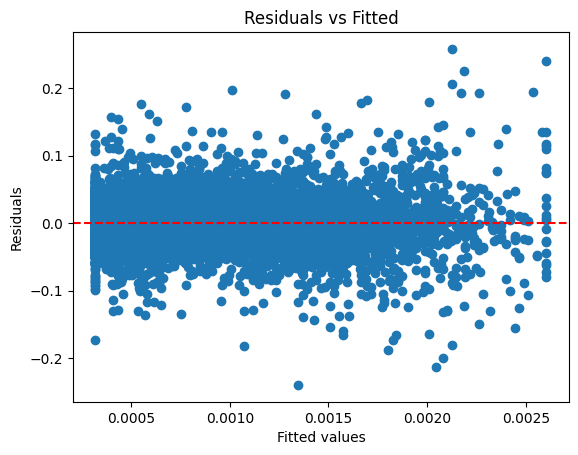

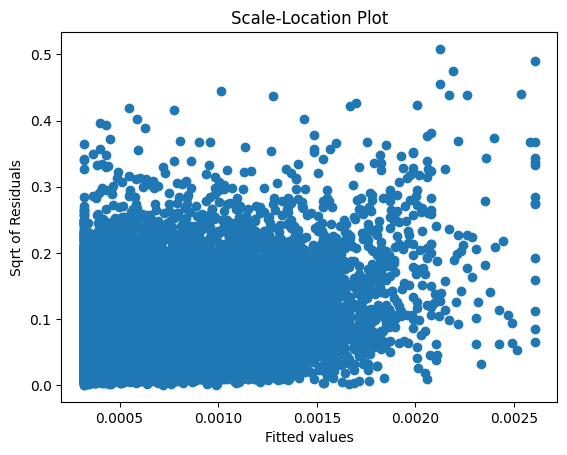

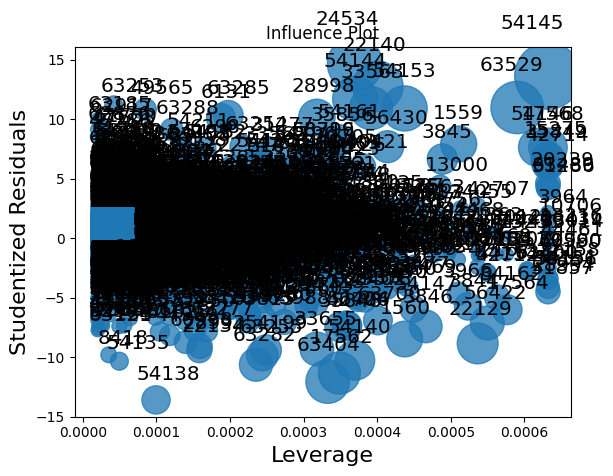

In [18]:
# QQ plot for normality of residuals
fig = sm.qqplot(results.resid, line='45', fit=True)
plt.title('Normal Q-Q Plot')
plt.show()

# Residuals vs Fitted for homoscedasticity
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Scale-Location plot (also called Spread-Location plot)
plt.scatter(results.fittedvalues, results.resid**0.5)
plt.xlabel('Fitted values')
plt.ylabel('Sqrt of Residuals')
plt.title('Scale-Location Plot')
plt.show()

# Leverage plot to find influential cases
sm.graphics.influence_plot(results, criterion="cooks")
plt.title('Influence Plot')
plt.show()

Given these results we will use a robust regression which does not have these assumptions. 

In [20]:
# create numpy arrays for each feature combination to later call in the OLS and robust regression 
X1 = df[['name_price_attention']]
X2 = df[['name_price_attention', 'mkt_cap']]
X3 = df[['name_price_attention', 'daily_volatility']]
X4 = df[['name_price_attention', 'volume']]
X5 = df[['name_price_attention', 'mkt_cap', 'daily_volatility']]
X6 = df[['name_price_attention', 'mkt_cap', 'volume']]
X7 = df[['name_price_attention', 'volume', 'daily_volatility']]
X8 = df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility']]

In [31]:
# create a robust regression for each feature combination
X1 = sm.add_constant(X1)
model1 = sm.RLM(y, X1, M=sm.robust.norms.HuberT())
results1 = model.fit()
print(results1.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:25                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [32]:
X2 = sm.add_constant(X2)
model2 = sm.RLM(y, X2, M=sm.robust.norms.HuberT())
results2 = model.fit()
print(results2.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:26                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [33]:
X3 = sm.add_constant(X3)
model3 = sm.RLM(y, X3, M=sm.robust.norms.HuberT())
results3 = model.fit()
print(results3.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:27                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [34]:
X4 = sm.add_constant(X4)
model4 = sm.RLM(y, X4, M=sm.robust.norms.HuberT())
results4 = model.fit()
print(results4.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:27                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [35]:
X5 = sm.add_constant(X5)
model5 = sm.RLM(y, X5, M=sm.robust.norms.HuberT())
results5 = model.fit()
print(results5.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:28                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [36]:
X6 = sm.add_constant(X6)
model6 = sm.RLM(y, X6, M=sm.robust.norms.HuberT())
results6 = model.fit()
print(results6.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:28                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [37]:
X7 = sm.add_constant(X7)
model7 = sm.RLM(y, X7, M=sm.robust.norms.HuberT())
results7 = model.fit()
print(results7.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:29                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [38]:
X8 = sm.add_constant(X8)
model8 = sm.RLM(y, X8, M=sm.robust.norms.HuberT())
results8 = model.fit()
print(results8.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:29                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [29]:
# print a regression table showing all the results 
from statsmodels.iolib.summary2 import summary_col
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[results,results,results,results,results,results,results,results],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6','Model 7','Model 8'],
                            info_dict=info_dict,
                            regressor_order=['const','name_price_attention', 'mkt_cap', 'daily_volatility', 'volume'])

results_table.add_title('Table 1 - OLS and Robust Regression Results')
print(results_table)

                        Table 1 - OLS and Robust Regression Results
                     Model 1  Model 2  Model 3  Model 4  Model 5  Model 6  Model 7  Model 8 
--------------------------------------------------------------------------------------------
const                0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00*** 
                     (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)  
name_price_attention 0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00*** 
                     (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)  
mkt_cap              0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00*** 
                     (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)  
daily_volatility     0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00*** 
                     (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)  
vo

In [40]:
# Create a summary table
from statsmodels.iolib.summary2 import summary_col

# You can customize the summary table further as needed
results_table = summary_col(models,
                             stars=True,
                             model_names=[
                                 'Model1', 'Model2', 'Model3',
                                 'Model4', 'Model5', 'Model6',
                                 'Model7', 'Model8'
                             ],
                             info_dict={
                                 'R2': lambda x: f"{x.rsquared:.2f}",
                                 'No. observations': lambda x: f"{int(x.nobs)}"
                             })

print(results_table)



NameError: name 'models' is not defined